In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")




/home/ubuntu/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [3]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [4]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [5]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


**LASSO with coordinate descent**

In [ ]:
mlflow.set_experiment("Lasso CD genetics")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i / 100 for i in range(5, 55, 5)]
results = []  

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('LASSO regression test' + "\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0




'''Param 1'''

for ripartition in ripartisions:


    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test": None, "Y_pred": None, "seed": None,"alpha":None}


    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
    
        i = 0
        for i in range(trials):
            print("Ripartion: " + str(ripartition) + " - trial: " + str(i))
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 0], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
                best_MSE_1 = MSE_param1[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_cd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.log_metric("alpha1", best_data_1["alpha"])



        MSE_param2 = []
        best_MSE_2 = 100000000
        best_data_2 = {"Y_test": None, "Y_pred": None, "seed": None, "alpha":None}
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 1], test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.predict(X_test)
    
            #save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
                best_MSE_2 = MSE_param2[-1]
                best_data_2["Y_test"] = Y_test
                best_data_2["Y_pred"] = Y_pred_lasso_cd
                best_data_2["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_2["seed"] = seeds[i]

            
       
        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        mlflow.log_metric("alpha2", best_data_2["alpha"])
            
    results.append([str(ripartition * 100), str(best_MSE_1), str(best_MSE_2),
                    (np.mean(MSE_param1)), str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)),
                    str(best_data_1["alpha"]), str(best_data_2["alpha"]), best_data_1["seed"],best_data_2["seed"]])

    
    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Lasso Regression with Coordinate Descent" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title(
        "Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n" + " alpha= " + str(best_data_1["alpha"]))

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title(
        "Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n" + " alpha= " + str(best_data_2["alpha"]))
    k += 1


'''SHOW RESULTS'''
headers = ["Test size(%)", "Best(MSE1)", "Best(MSE2)", "Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)",
           "alpha1","alpha2","Seed1","Seed2"]

print(tabulate(results, headers, tablefmt="double_outline"))




**LASSO with coordinate descent NRMSEPiqr**

0.25 ripartition
Trial:  1
Trial:  2
Trial:  3
Trial:  4
Trial:  5
Trial:  6
Trial:  7
Trial:  8
Trial:  9
Trial:  10
Trial:  11
Trial:  12
Trial:  13
Trial:  14
Trial:  15
Trial:  16
Trial:  17
Trial:  18
Trial:  19
Trial:  20
Trial:  21
Trial:  22
Trial:  23
Trial:  24
Trial:  25
Trial:  26
Trial:  27
Trial:  28
Trial:  29
Trial:  30
Trial:  31
Trial:  32
Trial:  33
Trial:  34
Trial:  35
Trial:  36
Trial:  37
Trial:  38
Trial:  39
Trial:  40
Trial:  41
Trial:  42
Trial:  43
Trial:  44
Trial:  45
Trial:  46
Trial:  47
Trial:  48
Trial:  49
Trial:  50
Trial:  51
Trial:  52
Trial:  53
Trial:  54
Trial:  55
Trial:  56
Trial:  57
Trial:  58
Trial:  59
Trial:  60
Trial:  61
Trial:  62
Trial:  63
Trial:  64
Trial:  65
Trial:  66
Trial:  67
Trial:  68
Trial:  69
Trial:  70
Trial:  71
Trial:  72
Trial:  73
Trial:  74
Trial:  75
Trial:  76
Trial:  77
Trial:  78
Trial:  79
Trial:  80
Trial:  81
Trial:  82
Trial:  83
Trial:  84
Trial:  85
Trial:  86
Trial:  87
Trial:  88
Trial:  89
Trial:  90
Tr

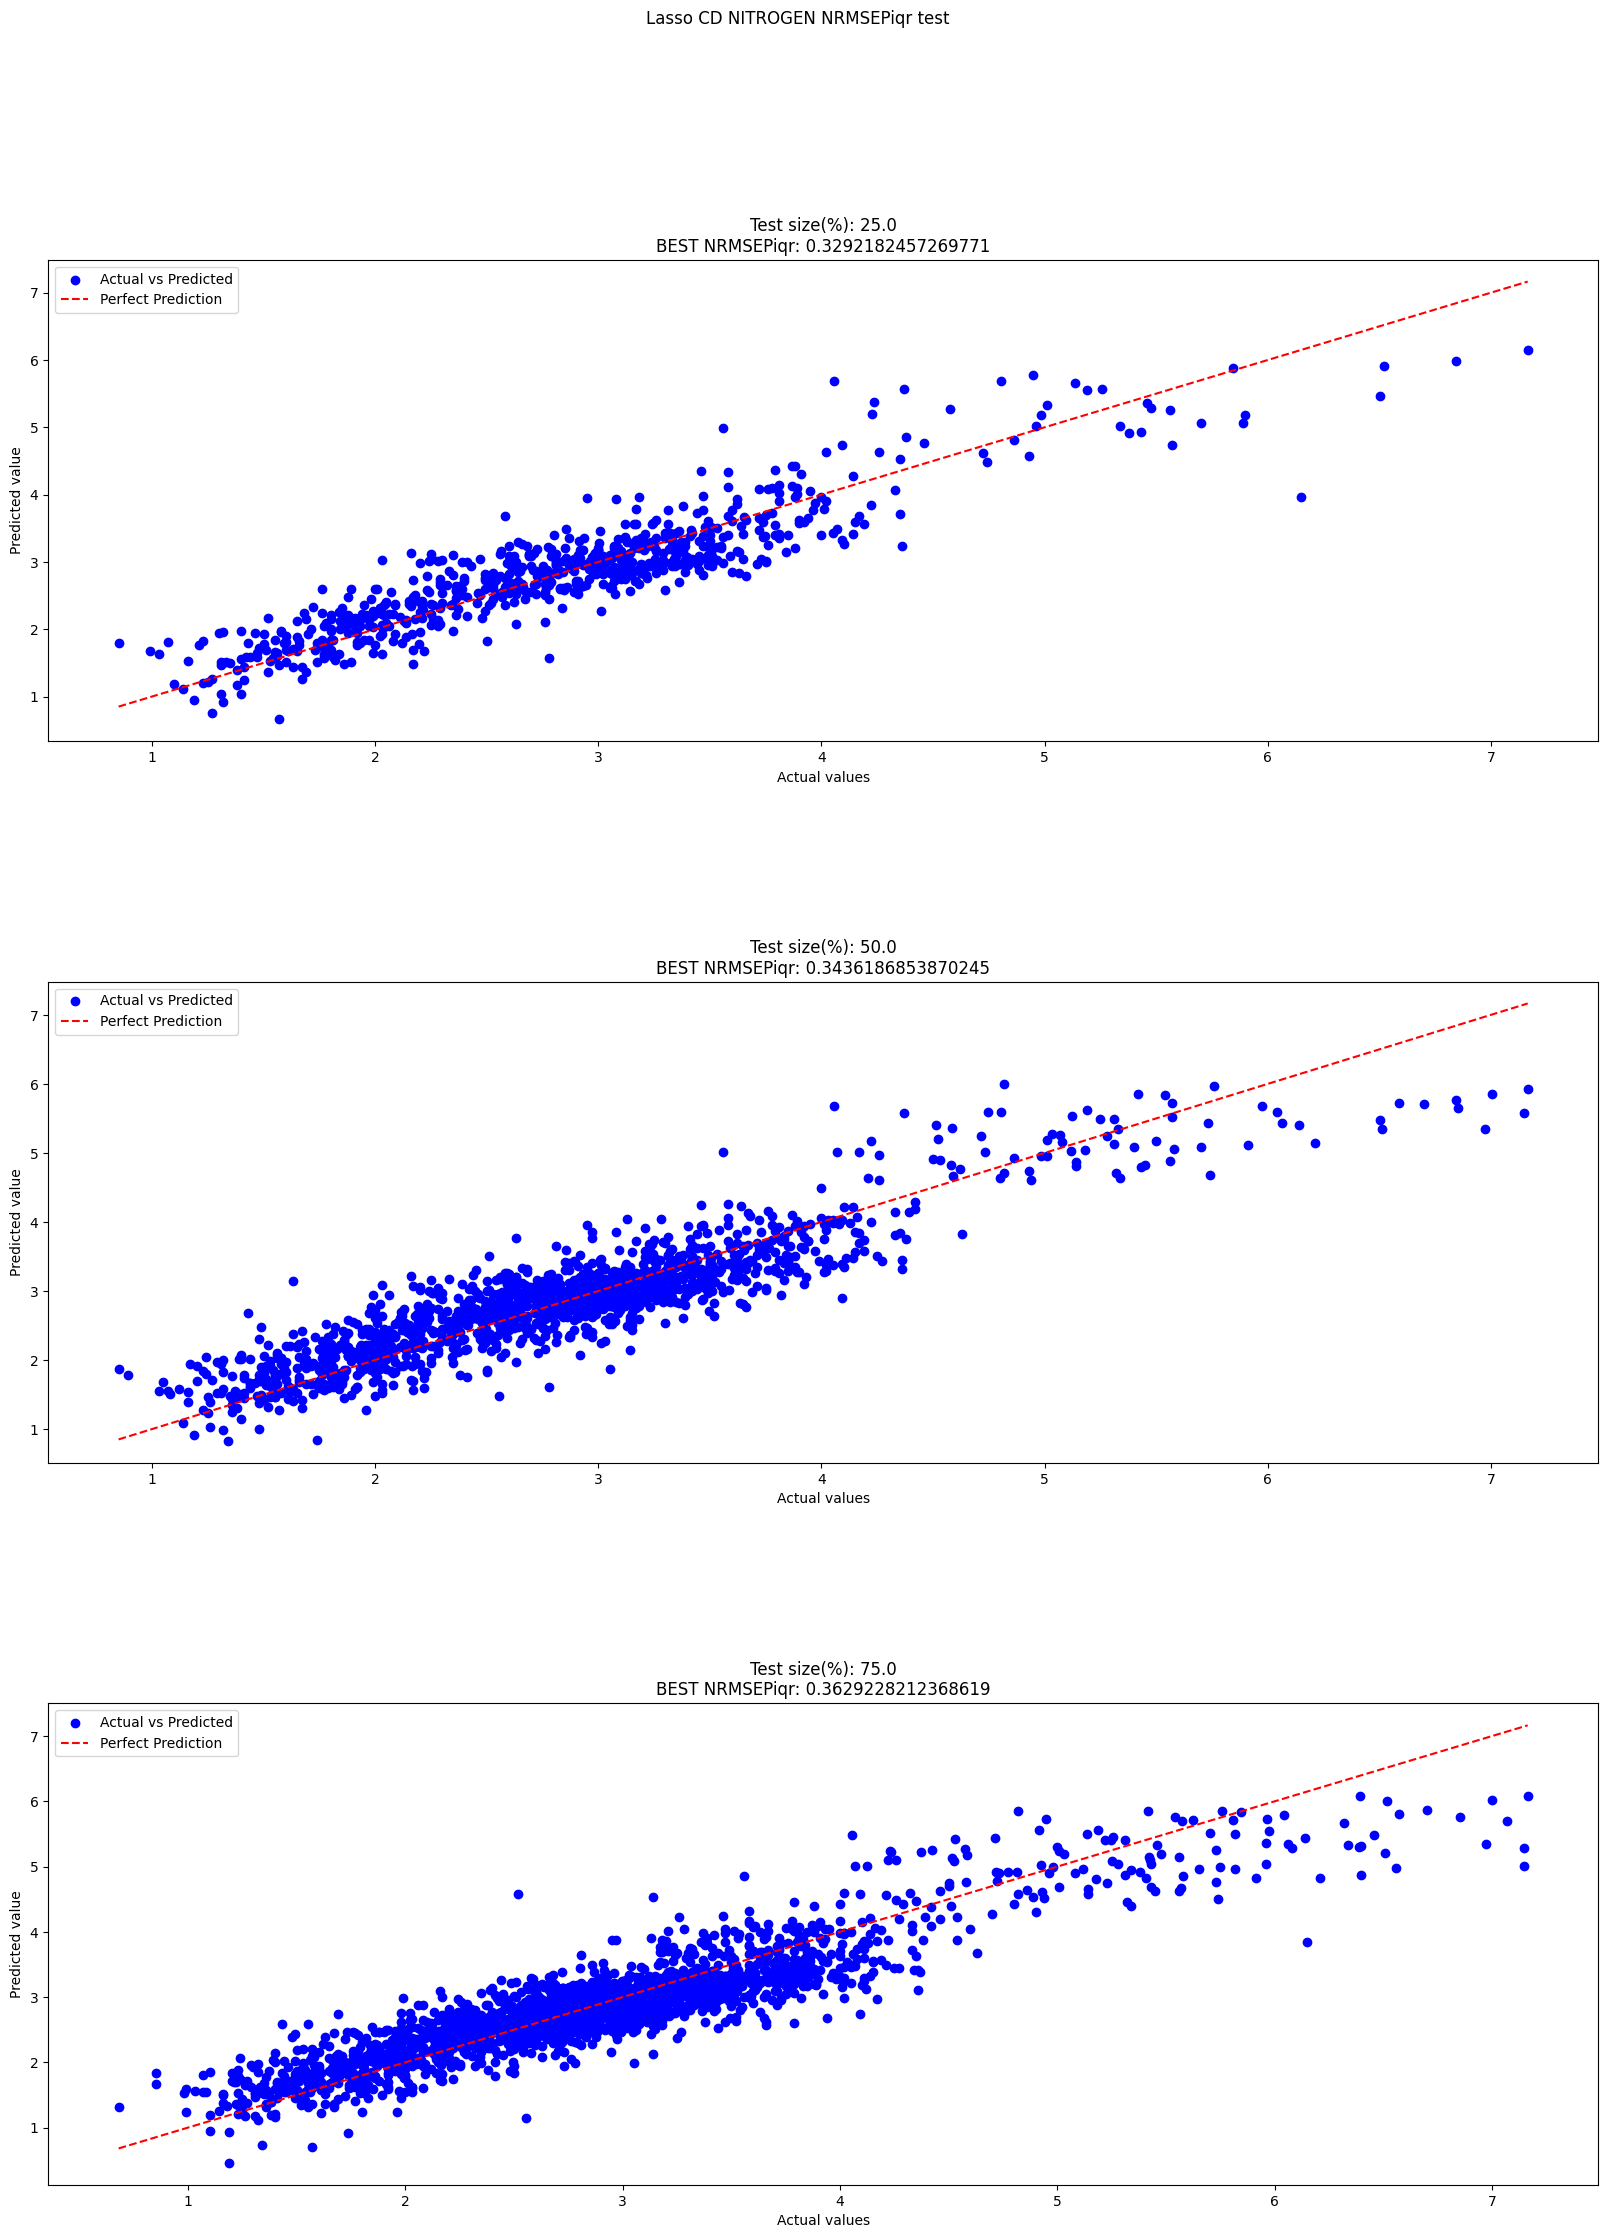

In [6]:




if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso CD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0




'''NITROGEN'''

for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}



        run_name = str(ripartition) + " ripartition"
        print(run_name)

        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            X_train= std_scaler.fit_transform(X_train)
            X_test= std_scaler.transform(X_test)
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_cd = Lasso(max_iter=5000, tol=1e-2)
    
                    
            evolved_estimator = GASearchCV(estimator=lasso_reg_cd,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=False,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
            # Make predictions using the testing set
            Y_pred_lasso_cd = evolved_estimator.best_estimator_.predict(X_test)
    
            
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_cd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_cd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time



        results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time(sec)"]

print(tabulate(results, headers,  tablefmt="double_outline"))




**LASSO with SGD**

In [ ]:
mlflow.set_experiment("Lasso SGD genetics Nitrogen MSE")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso SGD NITROGEN MSE test'+"\n")
axs = axs.flatten()
k = 0


for ripartition in ripartisions:

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    

    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        print(run_name)

        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l1", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=lasso_reg_sgd,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10)
    
            #grid search will contain the best model
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_lasso_sgd =  evolved_estimator.predict(X_test)
    
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_lasso_sgd))
    
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_lasso_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_MSE", best_MSE_1)
        mlflow.log_metric("Mean_MSE", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE", np.var(MSE_param1))
        mlflow.log_metric("alpha", best_data_1["alpha"])
        mlflow.log_metric("seed", best_data_1["seed"])
        
    results.append([str(ripartition *100 ), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**LASSO with SGD NITROGEN**

In [13]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 
#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0


for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        

        run_name = str(ripartition) + " ripartition"
        print(run_name)

        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            lasso_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l1", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=lasso_reg_sgd,
                              cv=5,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=10,
                              generations=10,
                              criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time)/60 #elapsed time in minute
    
            # Make predictions using the testing set
            Y_pred_lasso_sgd =  evolved_estimator.predict(X_test)
    
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_lasso_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_lasso_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time

        
        results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time (min)"]

print(tabulate(results, headers,  tablefmt="double_outline"))



0.25 ripartition
Trial:  1
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.789432	0.0585422  	-0.693824  	-0.881485  
1  	20    	-0.847781	0.0381339  	-0.781961  	-0.881485  
2  	20    	-0.869646	0.0263883  	-0.792099  	-0.881485  
3  	20    	-0.866906	0.030338   	-0.789538  	-0.882163  
4  	20    	-0.87419 	0.0218142  	-0.808824  	-0.882163  
5  	20    	-0.874634	0.0219375  	-0.808824  	-0.882163  
6  	20    	-0.862229	0.0238511  	-0.827719  	-0.882163  
7  	20    	-0.854468	0.0269255  	-0.807738  	-0.882163  
8  	20    	-0.877744	0.00722557 	-0.856404  	-0.88226   
9  	20    	-0.880496	0.00151011 	-0.87752   	-0.88226   
10 	20    	-0.86811 	0.0201937  	-0.827521  	-0.88226   
Trial:  2
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.811924	0.0596792  	-0.696237  	-0.881136  
1  	20    	-0.861092	0.029802   	-0.796931  	-0.883445  
2  	20    	-0.876492	0.00951156 	-0.851578  	-0.883832  
3  	20    	-0.854409	0.055553   	-0.700881  	-0.883